In [1]:
"""Offset and UPDRS correlation."""
%load_ext autoreload
%autoreload 2
from analysis_settings import *
from plot_settings import *
from scripts.utils_plot import _save_fig, _corr_results, _plot_legend, convert_pvalue_to_asterisks
from scripts.corr_stats import independent_corr, compare_corrs_perm
# from statannotations.Annotator import Annotator  # does not work
import numpy as np
from warnings import warn

## to do:
- bold fontweight does not work for significant rho
- position text better
- high beta no longer significantly larger in periodic vs normalized
- high beta no longer significantly different OFF vs ON

- > figure too small for correlation plot. Instead, use bar plot of 4 correlation
coefficients in single axis. Indicate 95% confidence interval with error bars,
show p-values using asterisk. Disadvantage: more abstract and relationship harder to understand..
- Only adjacent channels implemented. For details, check NotImplementedError message.

In [15]:
def plot_corrs_highbeta_off(df_corr, add_ci=True):
    band = df_corr['band'].iloc[0]
    n_perm = df_corr['n_perm'].iloc[0]
    fig_name = f'Figure4/sweetspot_{band}_off_corr_nperm={n_perm}.pdf'
    kinds = list(df_corr['kind'].unique())
    colors = df_corr['colors'].unique()

    fig, ax = plt.subplots(1, 1, figsize=(2, 1.7))
    # plotting_parameters = {'ax': ax, 'data': df_corr, 'x': 'kind', 'y': 'rho'}
    # sns.barplot(**plotting_parameters)
    ci_arr = np.array([
        [df_corr['ci'][0][0] - df_corr['rho'][0],
         df_corr['ci'][1][0] - df_corr['rho'][1],
         df_corr['ci'][2][0] - df_corr['rho'][2]],
        [df_corr['ci'][0][1] - df_corr['rho'][0],
         df_corr['ci'][1][1] - df_corr['rho'][1],
         df_corr['ci'][2][1] - df_corr['rho'][2]]
        ])
    ci_arr = np.abs(ci_arr)  # lower and upper automatically subtracted
    # ax.errorbar(x=np.arange(3), y=df_corr['rho'], yerr=ci_arr)

    if add_ci:
        ax.bar(x=kinds, height=df_corr['rho'], yerr=np.abs(ci_arr),
               color=colors)
    else:
        ax.bar(x=kinds, height=df_corr['rho'], color=colors)
    # ax.set_xticklabels([kind.capitalize() for kind in kinds])
    ax.set_xticklabels([cfg.PLOT_LABELS[kind] for kind in kinds])

    # add significance star for bars where pval < 0.05
    if add_ci:
        bars = ax.containers[1]
    else:
        bars = ax.containers[0]
    ymax, ymin = ax.get_ylim()
    yscale = np.abs(ymax - ymin)
    y_buffer = 0.03*yscale
    pvals_high_beta_off = df_corr['pvals']
    for i, bar in enumerate(bars):
        pvalue = pvals_high_beta_off[i]
        text = convert_pvalue_to_asterisks(pvalue)
        x_bar = bar.get_x() + bar.get_width() / 2
        ax.annotate(text, xy=(x_bar, ymax - y_buffer), ha='center', va='top',
                    fontsize=FONTSIZE_ASTERISK)

    pval_norm_abs = df_corr['pval_norm_abs'].iloc[0]
    pval_abs_per = df_corr['pval_abs_per'].iloc[0]
    pval_norm_per = df_corr['pval_norm_per'].iloc[0]
    annotations = [('normalized', 'absolute', pval_norm_abs),
                   ('absolute', 'periodic', pval_abs_per),
                   ('normalized', 'periodic', pval_norm_per)]

    height_stat = ymax # + 0*y_buffer
    # Loop through each annotation
    for (x1_label, x2_label, pvalue) in annotations:
        # Get the indices of the bars from the 'kinds' list
        x1 = kinds.index(x1_label)
        x2 = kinds.index(x2_label)

        height_stat -= 3.5*y_buffer

        # Determine the y position for the line and asterisk
        # y_max = max(y1, y2)  # Start from the higher bar
        y_line = height_stat + 1.5*y_buffer  # Add some offset for the line
        y_text = y_line - y_buffer/2  # Add a little more offset for the asterisks

        # Draw the line connecting the two bars
        ax.plot([x1, x1, x2, x2],
                [y_line, y_line - y_buffer/2, y_line - y_buffer/2, y_line],
                color='black')

        # Get the significance text based on the p-value
        text = convert_pvalue_to_asterisks(pvalue, print_ns=True)

        # Place the text above the line
        ax.text((x1 + x2) / 2, y_text, text,
                ha='center', va='bottom', fontsize=FONTSIZE_ASTERISK)

    # starbars.draw_annotation(annotations)
    ax.set_ylabel(r'Spearmans $\rho$')
    ax.invert_yaxis()
    ax.set_title(f'{cfg.BAND_NAMES_GREEK[band]} power {cfg.COND_DICT['off']} ~ sweet spot distance')
    sns.despine()
    ax.set_xlabel(None)
    plt.tight_layout()
    _save_fig(fig, fig_name, SAVE_DIR, close=False, bbox_inches=None,
              transparent=True)


def plot_sweetspot_distance(adjacent=True,
                            # plot_only_maxima=True,
                            add_units_xlabel=True, n_perm=10000,
                            pval_off_vs_on=False, exclude_zero=False,
                            bands=['beta_low', 'beta_high']):
    # Get df
    df = pd.read_pickle(join('..', cfg.DF_PATH, cfg.DF_FOOOF))
    if adjacent:
        bip_chs = ['LFP_1-2', 'LFP_2-3', 'LFP_3-4']
    else:
        msg = ('Only adjacent channels implemented. Arithmetic mean of bip '
               'channels not reasonable due to large distance. '
               'More reasonable: Select sweetspot '
               'channel + distant ref channel. Requires significant coding '
               'because one would need to calc sweetspot distance for all '
               'distant channel pairs and then select minimum for each pair '
               'to enable proper choice.')
        raise NotImplementedError(msg)
        bip_chs = ['LFP_1-3', 'LFP_2-4']
    df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond
    df = df[~df.ch_bad & df.cond.isin(['on', 'off'])
            & df.mni_x.notna() & df.ch.isin(bip_chs)
            & df.project.isin(['all'])]
    df_norm = df[(df.psd_kind == 'normalized') & (df.fm_params == False)]
    df_abs = df[(df.psd_kind == 'standard') & (df.fm_params == 'broad')
                 & df.fm_exponent.notna()]
    # equalize subjects for comparison
    df_norm = df_norm[df_norm.sub_hemi_cond.isin(df_abs.sub_hemi_cond.unique())]

    # Collect kind data
    rhos_high_beta_off = []
    pvals_high_beta_off = []
    CIs = []
    xvalues_kinds = []
    yvalues_kinds = []

    # Settings
    kinds = ['normalized', 'absolute', 'periodic']
    color_dict = dict(off='k', on='grey')
    y = 'sweet_spot_distance'
    for kind in kinds:
        df_kind = df_norm.copy() if kind == 'normalized' else df_abs.copy()
        pwr = '_fm_powers_max_log' if kind == 'periodic' else '_abs_max_log'
        if add_units_xlabel:
            if kind == 'normalized':
                units = ' [log10(%)]'
            elif kind == 'absolute':
                units = ' [log10(µV²/Hz)]'
            elif kind == 'periodic':
                units = ' [log10(µV²/Hz)-1]'
        else:
            units = ' Power'

        fig, axes = plt.subplots(1, len(bands), figsize=(2.2, 1.5), sharey=True)
        for i, band in enumerate(bands):
            pwr_col = band + pwr
            ax = axes[i]
            rhos = []
            sample_sizes = []
            labels = []
            weights = []
            try:
                color_dict['off'] = cfg.BAND_COLORS[band]
            except KeyError:
                color_dict['off'] = 'k'
            for cond in ['off', 'on']:
                ch_max = f'ch_chmax_{pwr_col}_{cond}'
                df_plot = df_kind[df_kind[ch_max].fillna(False)]
                df_plot = df_plot[df_plot.cond == cond]

                sns.regplot(ax=ax, data=df_plot, x=pwr_col, y=y,
                                    color=color_dict[cond],
                                    ci=CI,  # CI only correct for pearson, not for spearman
                                    scatter_kws=dict(s=8, alpha=1, edgecolor='k',
                                                        linewidths=.1),
                                    label=cfg.COND_DICT[cond],
                                    line_kws=dict(linewidth=LINEWIDTH_PLOT),
                                    marker='.')
                row_idx = cond if i == 0 else None
                corr_results = _corr_results(df_plot.set_index('cond'), pwr_col,
                                            y, 'spearman', row_idx,
                                            n_perm=n_perm,
                                            add_sample_size=False)
                rho, sample_size, label, weight, ci = corr_results
                band_final = bands[-1]
                if band == band_final and cond == 'off':
                    rho_high_beta_off = rho
                    idx = label.find('p=')
                    pval_high_beta_off = float(label[idx:].strip('p='))
                    ci_high_beta_off = ci
                    xvals = df_plot[pwr_col].values
                    yvals = df_plot[y].values
                rhos.append(rho)
                sample_sizes.append(sample_size)
                labels.append(label)
                weights.append(weight)
                handles, _ = ax.get_legend_handles_labels()
            _plot_legend(ax, pwr_col, y, labels, weights, 'cond', rhos,
                        sample_sizes, title_long=False, handles=handles[:2],
                        xylabels=False, leg_kws={'frameon': False},
                        bbox_to_anchor=(-.125, 1.02, 1, 0.2),
                        corr_comparison=pval_off_vs_on)
            try:
                ax.set_xlabel(cfg.BAND_NAMES_GREEK[band] + units)
            except KeyError:
                ax.set_xlabel(band + units)

        axes[0].set_ylabel(None)
        axes[1].set_ylabel(None)
        plt.tight_layout()
        plt.subplots_adjust(wspace=0.05)
        band_str = '_'.join(bands)
        fig_name = f'Figure4/sweetspot_correlation_{band_str}_{kind}_nperm={n_perm}.pdf'
        _save_fig(fig, fig_name, SAVE_DIR, close=False, transparent=True,
                bbox_inches=None)

        rhos_high_beta_off.append(rho_high_beta_off)
        pvals_high_beta_off.append(pval_high_beta_off)
        xvalues_kinds.append(xvals)
        yvalues_kinds.append(yvals)
        CIs.append(ci_high_beta_off)

    groupby = ['subject', 'ch_hemisphere']
    group = df[(df.cond == 'off') & df.fm_has_model].groupby(groupby)
    n = len(group.size())

    if n_perm is None:
        rho_norm_off, rho_abs_off, rho_per_off = rhos_high_beta_off
        _, pval_norm_abs = independent_corr(rho_norm_off, rho_abs_off, n, n,
                                            twotailed=False)
        _, pval_abs_per = independent_corr(rho_abs_off, rho_per_off, n, n,
                                            twotailed=False)
        _, pval_norm_per = independent_corr(rho_norm_off, rho_per_off, n, n,
                                            twotailed=False)
    elif isinstance(n_perm, int):
        x_norm_off, x_abs_off, x_per_off = xvalues_kinds
        y_norm_off, y_abs_off, y_per_off = yvalues_kinds
        pval_norm_abs = compare_corrs_perm(x_norm_off, y_norm_off,
                                           x_abs_off, y_abs_off, n_perm=n_perm,
                                           tail='r1_greater')
        pval_abs_per = compare_corrs_perm(x_abs_off, y_abs_off,
                                          x_per_off, y_per_off, n_perm=n_perm,
                                          tail='r1_greater')
        pval_norm_per = compare_corrs_perm(x_norm_off, y_norm_off,
                                           x_per_off, y_per_off, n_perm=n_perm,
                                           tail='r1_greater')


    print(f'pval_norm_abs: {pval_norm_abs}')
    print(f'pval_abs_per: {pval_abs_per}')
    print(f'pval_norm_per: {pval_norm_per}')

    df_corr = {'band': [band] * 3,
               'kind': kinds,
               'rho': rhos_high_beta_off,
               'pvals': pvals_high_beta_off,
               'ci': CIs,
               'colors': [cfg.COLOR_DIC[kind] for kind in kinds],
               'cond': ['OFF'] * 3,
               'sample_sizes': n,
               'n_perm': n_perm,
               'pval_norm_abs': pval_norm_abs,
               'pval_abs_per': pval_abs_per,
               'pval_norm_per': pval_norm_per}
    df_corr = pd.DataFrame(df_corr)

    plot_corrs_highbeta_off(df_corr, add_ci=False)

In [16]:
n_perm = 10000
# n_perm = None

/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_91575/1779094144.py:109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub_hemi_cond'] = df.sub_hemi + '_' + df.cond


pval_norm_abs: 0.16718328167183283
pval_abs_per: 0.1715828417158284
pval_norm_per: 0.026197380261973803


/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_91575/1779094144.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([cfg.PLOT_LABELS[kind] for kind in kinds])


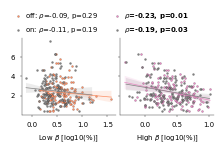

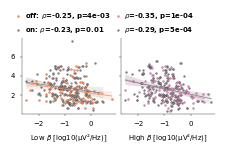

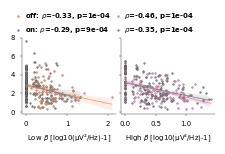

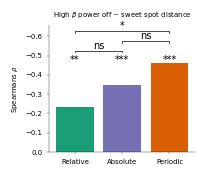

In [17]:
plot_sweetspot_distance(n_perm=n_perm)

In [5]:
# plot_sweetspot_distance(n_perm=n_perm, bands=['theta', 'gamma_low'])